# Chapter 3 Questions

#### 3.1 Form dollar bars for E-mini S&P 500 futures:
1. Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).
2. Use Snippet 3.4 on a pandas series t1, where numDays=1.
3. On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.
4. Apply getBins to generate the labels.

In [1]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml

In [2]:
import numpy as np
import pandas as pd
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv', nrows=40000)
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [4]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


**Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).**

In [5]:
# Compute daily volatility
vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

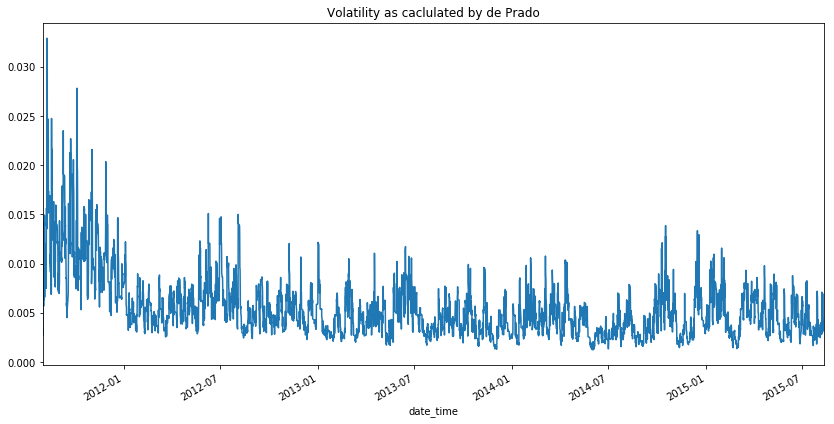

In [6]:
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

In [7]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=vol.mean())

**Use Snippet 3.4 on a pandas series t1, where numDays=1.**

In [8]:
# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(cusum_events, data['close'])
vertical_barriers.head()

2011-08-01 10:51:41.842   2011-08-02 10:52:48.191
2011-08-01 13:36:46.215   2011-08-02 13:37:28.849
2011-08-01 14:00:21.448   2011-08-02 14:04:29.869
2011-08-01 14:03:22.782   2011-08-02 14:04:29.869
2011-08-01 14:21:49.179   2011-08-02 14:27:55.423
Name: date_time, dtype: datetime64[ns]

**On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.**

In [9]:
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=[1, 1],
                                               target=vol,
                                               min_ret=0.01,
                                               num_threads=1,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=None)

/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/mlfinlab/labeling/labeling.py:117: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [10]:
triple_barrier_events.head()

,t1,trgt
2011-08-04 01:57:00.466,2011-08-04 10:27:24.326,0.011841
2011-08-04 09:08:28.542,2011-08-04 12:43:40.327,0.012108
2011-08-04 10:27:24.326,2011-08-04 14:58:04.748,0.011682
2011-08-04 12:29:39.619,2011-08-04 15:01:19.020,0.011022
2011-08-04 19:44:06.743,2011-08-05 13:54:12.782,0.011423


In [11]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])

In [12]:
labels.head()

,ret,trgt,bin
2011-08-04 01:57:00.466,-0.016254,0.011841,-1
2011-08-04 09:08:28.542,-0.012762,0.012108,-1
2011-08-04 10:27:24.326,-0.011686,0.011682,-1
2011-08-04 12:29:39.619,-0.011907,0.011022,-1
2011-08-04 19:44:06.743,-0.012887,0.011423,-1


In [13]:
labels['bin'].value_counts()

 1    255
-1    207
 0    198
Name: bin, dtype: int64

---
#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [14]:
clean_labels = ml.labeling.drop_labels(labels)

In [15]:
print(labels.shape)
print(clean_labels.shape)

(660, 3)
(660, 3)


---
#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.
This change was made inside the module CoreFunctions.

---
#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, themodel suggests a side, but not a size of the bet.

1. Derive meta-labels for pt_sl = [1,2] and t1 where num_days=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
2. Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underllying model (the crossing moveing average has decided the side{-1, 1})

In [16]:
# This question is answered in the notebook: 2019-03-06_JJ_Trend-Following-Question

----
#### 3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [17]:
# This question is answered in the notebook: 2019-03-07_BBand-Question